In [1]:
# !pip install kaggle --upgrade
# !pip show kaggle

# !kaggle config view
# !kaggle competitions download -c dogs-vs-cats

import os
import zipfile
from tqdm import tqdm

In [2]:
data = 'dogs-vs-cats'

# # 압축파일 풀기 :하위 폴더 data에 풀기
# with zipfile.ZipFile(f'{data}.zip', 'r') as existing_zip:
#     existing_zip.extractall(f'./{data}')

In [3]:
train_data = os.path.join(data,'train')
test_data = os.path.join(data,'test1')

# zip_file = zipfile.ZipFile(os.path.join(data,'train.zip'))
# zip_file.extractall(path=data)
# zip_file.close()

# zip_file = zipfile.ZipFile(os.path.join(data,'test1.zip'))
# zip_file.extractall(path=data)
# zip_file.close()


In [4]:

# 데이터의 갯수
trainFiles = os.listdir(train_data)
testFiles = os.listdir(test_data)

# train : 12500개 cat, 12500개 dog
print(len(trainFiles))
# test : 레이블이 없는 이미지 12500개
print(len(testFiles))

25000
12500


In [5]:
import random
num = random.randint(0,len(trainFiles))
trainFiles[num]

'dog.6511.jpg'

In [6]:
# cat : 12500, dog : 12500 갯수 확인하기
trainFiles[0].split('.')[0]

'cat'

In [7]:
# 이미지 분류 레이블을 만드는 방법
# 방법 1은 폴더로 클래스를 나누는 방법 : 폴더명이 레이블로 사용하는 방법
# 방법 2는 csv파일을 만든다. csv파일의 컬럼을 2개 (column1 : 파일명, column2 : 레이블)

# 훈련 데이터 전체 25000장, 이거 다쓰면... 오늘 진도 못나가요...
# 연습시에는 데이터 2000장만 사용
# train: 1000장, 1000장, valid : 500장, 500장, test: 500장, 500장

In [8]:
import os
import shutil

# 데이터셋 디렉토리 경로 설정 (데이터셋이 저장된 경로로 수정하세요)
org_train_dir = 'dogs-vs-cats/train'
org_test_dir = 'dogs-vs-cats/test1'

# 새로운 train, valid, test 디렉토리 생성 경로
base_dir = 'sdata'

# 클래스 목록
classes = ['dog', 'cat']

# 폴더 경로 생성
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 폴더 생성 함수
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# train, valid, test 폴더 및 각각의 클래스 폴더 생성
for cls in classes:
    create_dir(os.path.join(train_dir, cls))
    create_dir(os.path.join(valid_dir, cls))
    create_dir(os.path.join(test_dir, cls))

# 이미지 복사 함수
def copy_images(start_idx, end_idx, src_dir, dst_dir, label):
    for i in range(start_idx, end_idx + 1):
        file_name = f'{label}.{i}.jpg'
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)

# 한 클래스의 이미지 갯수
train_num = 1000
valid_num = 500
test_num  = 500

train_range = [0, train_num-1]
valid_range = [train_num, train_num + test_num -1]
test_range  = [train_num + test_num, train_num + valid_num + test_num-1]

print(train_range)
print(valid_range)
print(test_range)

# 클래스별로 train, valid, test 데이터셋 구성
for cls in classes:
    print(cls)
    copy_images(train_range[0], train_range[1], org_train_dir, os.path.join(train_dir, cls), cls)
    
    copy_images(valid_range[0], valid_range[1], org_train_dir, os.path.join(valid_dir, cls), cls)

    copy_images(test_range[0], test_range[1], org_train_dir, os.path.join(test_dir, cls), cls)

print("데이터셋 분할 및 복사가 완료되었습니다.")

[0, 999]
[1000, 1499]
[1500, 1999]
dog
cat
데이터셋 분할 및 복사가 완료되었습니다.


In [9]:
# 위에서 복사된 파일들 갯수 확인하기
train_cat = os.listdir(os.path.join(train_dir,'cat'))
train_dog = os.listdir(os.path.join(train_dir,'dog'))
valid_cat = os.listdir(os.path.join(valid_dir,'cat'))
valid_dog = os.listdir(os.path.join(valid_dir,'dog'))
test_cat = os.listdir(os.path.join(test_dir,'cat'))
test_dog = os.listdir(os.path.join(test_dir,'dog'))

# 위의 6개 폴더 파일 갯수 확인하기
for i in [train_cat, train_dog, valid_cat, valid_dog, test_cat, test_dog]:
    print(len(i))

1000
1000
500
500
500
500


In [10]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# 이미지 4000장을 CustomDataset 클래스를 만들어서 사용
class CustomDataset(Dataset):
    def __init__(self, files, root_dir, mode, transform=None):
        self.files = files
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        # 레이블 생성 cat=0, dog=1
        if 'dog' in files[0]:
            self.label = 1
        else:
            self.label = 0

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, np.array([self.label])

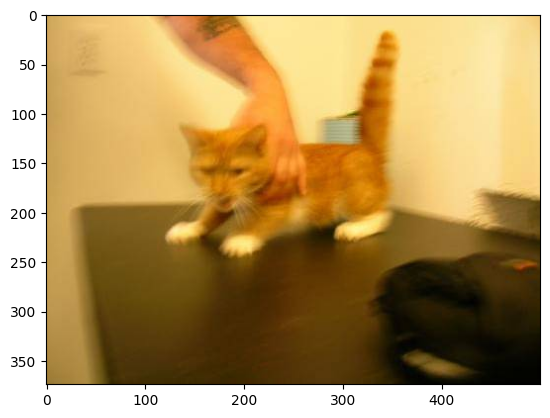

In [11]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('sdata/train/cat/cat.0.jpg') # cv2는 BGR로 읽어온다.
img2 = img[:,:,::-1] # RGB로 변환
plt.imshow(img2) # BGR로 출력

In [12]:
from torchvision import transforms

org_size =(256,256)
img_size = 224

train_transform = transforms.Compose([
    #이미지 사이즈가 파일마다 제 각각
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    # 평균이 0.5 표준편차 0.5 (0~1사이의 실수)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [13]:
# 파일 목록, 파일디렉토리, 모드, transform
train_dog_dataset = CustomDataset(train_dog, os.path.join(train_dir, 'dog'), 'train', transform=train_transform)
train_cat_dataset = CustomDataset(train_cat, os.path.join(train_dir, 'cat'), 'train', transform=train_transform)

valid_dog_dataset = CustomDataset(valid_dog, os.path.join(valid_dir, 'dog'), 'train', transform=test_transform)
valid_cat_dataset = CustomDataset(valid_cat, os.path.join(valid_dir, 'cat'), 'train', transform=test_transform)

test_dog_dataset = CustomDataset(test_dog, os.path.join(test_dir, 'dog'), 'test', transform=test_transform)
test_cat_dataset = CustomDataset(test_cat, os.path.join(test_dir, 'cat'), 'test', transform=test_transform)

from torch.utils.data import ConcatDataset

train_dataset = ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = ConcatDataset([test_dog_dataset, test_cat_dataset])

In [14]:
# dataLoader에 넣는다. dataLoader에서 batch_size만큼씩 데이터를 꺼낸다.

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7019608..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input dat

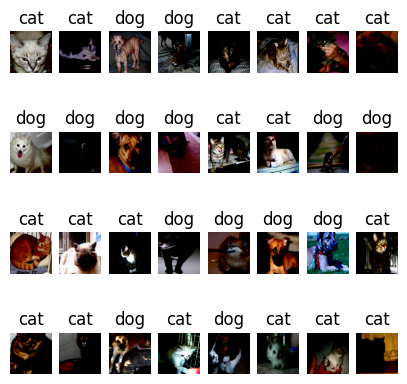

In [15]:
# train데이터가 2000장이 있는데, 32장씩 데이터를 가져온다.
img, label = next(iter(train_loader))
img.shape, label.shape

classes ={0:'cat',1:'dog'}

fig = plt.figure(figsize=(5, 5))
for i in range(batch_size):
    # 4행 8열
    ax = fig.add_subplot(4, 8, i + 1)
    ax.set_title(classes[label[i].item()])
    ax.axis('off')
    # 컬러 채널 순서를 재정렬
    ax.imshow(img[i].permute(1, 2, 0))

plt.show()

In [16]:
# 모델을 만들어서 학습시킨다.
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# pretrained=True은 옛날 버전이고 weigth= 해서 사용하라는데 그걸로 구현
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

# 특징 추출기는 그대로 사용하고, 분류기만 2개짜리로 변경
# fc -> 분류기 in_features -> 분류기의 입력
num_features = model.fc.in_features

# 이진 분류(binary classfication)
# 최종 출력 노드의 갯수 1개, (cf. 0.2가 나오면 0의 클래스일 확률이 높은 것)
# sigmoid()

# 다중 분류(multi classfication)
# 최종 출력 노드의 개수 2개, (cf. [0.8, 0.2], [0.3, 0.7])
# softmax()

# 모델의 마지막 레이어를 변경한다.
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
).to(device)


In [17]:
!pip install torchsummary
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
# 모델 학습

# 그래프로 출력하기 위한 리스트
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

def fit(model, criterion, optimizer, EPOCHS, train_loader, valid_loader):

    for epoch in range(EPOCHS):

        train_loss = 0
        train_correct = 0
        train_total = len(train_loader)

        # 1epoch중에 train에 해당하는 for문
        trainStr = f'Epoch {epoch+1:2d}/{EPOCHS} \033[34m' + 'Train ' + '\033[0m'
        with tqdm(total=train_total, desc=trainStr) as train_bar:
            for train_x, train_y in train_loader:
                model.train()
                train_x, train_y = train_x.to(device), train_y.to(device).float()

                optimizer.zero_grad()
                pred = model(train_x)
                loss = criterion(pred, train_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # 활성화 함수 sigmoid를 쓰면
                y_pred = pred.cpu()
                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0
                
                # train_y와 y_pred이 같으면 correct 갯수 추가
                train_correct += y_pred.eq(train_y.cpu()).int().sum()

                train_bar.update(1)
            
            train_loss = train_loss / train_total
            train_accuracy = train_correct / len(train_loader.dataset) * 100

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            endStr = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}%'
            train_bar.set_postfix_str(endStr)

        # validation에 해당하는 for문
        # validation data check
        valid_loss = 0
        valid_correct = 0
        valid_total = len(valid_loader)
        
        with torch.no_grad():
            validStr = f'Epoch {epoch+1:2d}/{EPOCHS} \033[34m' + 'Valid ' + '\033[0m'

            with tqdm(total=valid_loader.__len__(), desc=validStr) as valid_bar:
                for valid_x, valid_y in valid_loader:
                        model.eval()
                        valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                        pred = model(valid_x)
                        loss = criterion(pred, valid_y)

                        valid_loss += loss.item()

                        y_pred = pred.cpu()
                        y_pred[y_pred >= 0.5] = 1
                        y_pred[y_pred < 0.5] = 0
                        valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
                        
                        valid_bar.update(1)
        
                valid_loss = valid_loss / valid_total
                valid_accuracy = valid_correct / len(valid_loader.dataset) * 100

                valid_losses.append(valid_loss)
                valid_accuracies.append(valid_accuracy)
                
                endStr = f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}%'
                valid_bar.set_postfix_str(endStr)

        print('-'*110)

In [19]:
LR = 0.00001
EPOCHS = 10
# 손실함수
# 신경망에 sigmoid를 썼으므로 BCELoss()사용
# 만약 신경망에 softmax를 썼다면 CELoss()사용
criterion = torch.nn.BCELoss()
# optimizer정의
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# 학습

fit(model, criterion, optimizer, EPOCHS, train_loader, valid_loader)

Epoch  1/10 Valid : 100%|██████████| 32/32 [00:14<00:00,  2.27it/s, Valid Loss: 0.5856, Valid Acc: 65.5000%]


--------------------------------------------------------------------------------------------------------------


Epoch  2/10 Valid : 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, Valid Loss: 0.4046, Valid Acc: 92.8000%]


--------------------------------------------------------------------------------------------------------------


Epoch  3/10 Valid : 100%|██████████| 32/32 [00:05<00:00,  5.95it/s, Valid Loss: 0.2773, Valid Acc: 98.2000%]


--------------------------------------------------------------------------------------------------------------


Epoch  4/10 Valid : 100%|██████████| 32/32 [00:05<00:00,  6.16it/s, Valid Loss: 0.1483, Valid Acc: 98.8000%]


--------------------------------------------------------------------------------------------------------------


Epoch  5/10 Valid : 100%|██████████| 32/32 [00:04<00:00,  6.46it/s, Valid Loss: 0.0857, Valid Acc: 99.0000%]


--------------------------------------------------------------------------------------------------------------


Epoch  6/10 Valid : 100%|██████████| 32/32 [00:06<00:00,  5.19it/s, Valid Loss: 0.0606, Valid Acc: 99.0000%]


--------------------------------------------------------------------------------------------------------------


Epoch  7/10 Valid : 100%|██████████| 32/32 [00:05<00:00,  5.51it/s, Valid Loss: 0.0485, Valid Acc: 99.1000%]


--------------------------------------------------------------------------------------------------------------


Epoch  8/10 Valid : 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, Valid Loss: 0.0393, Valid Acc: 99.2000%]


--------------------------------------------------------------------------------------------------------------


Epoch  9/10 Valid : 100%|██████████| 32/32 [00:05<00:00,  5.86it/s, Valid Loss: 0.0329, Valid Acc: 99.2000%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/10 Valid : 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, Valid Loss: 0.0294, Valid Acc: 99.1000%]

--------------------------------------------------------------------------------------------------------------


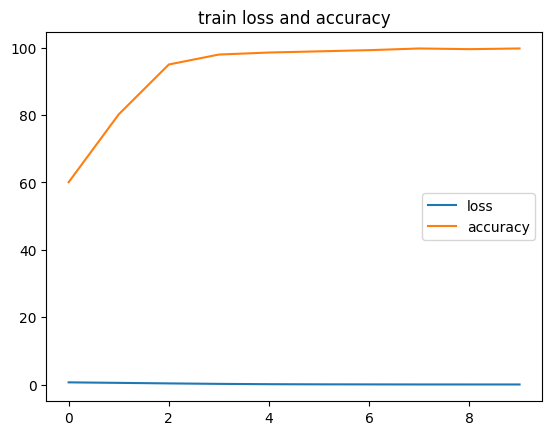

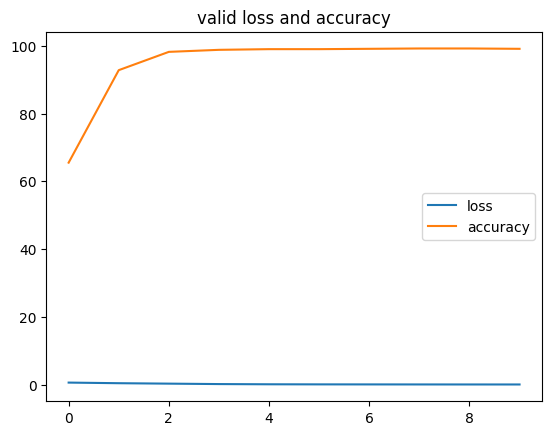

In [20]:

plt.plot(train_losses, label='loss')
plt.plot(train_accuracies, label='accuracy')
plt.legend()
plt.title('train loss and accuracy')
plt.show()

plt.plot(valid_losses, label='loss')
plt.plot(valid_accuracies, label='accuracy')
plt.legend()
plt.title('valid loss and accuracy')
plt.show()

In [21]:

def test(model, criterion, test_loader):
    test_loss = 0
    test_correct = 0
    test_total = len(test_loader)
        
    with torch.no_grad():
        testStr = f'\033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=test_loader.__len__(), desc=testStr) as test_bar:
            for test_x, test_y in test_loader:
                model.eval()
                test_x, test_y = test_x.to(device), test_y.to(device).float()
                pred = model(test_x)
                loss = criterion(pred, test_y)

                test_loss += loss.item()

                y_pred = pred.cpu()
                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0
                test_correct += y_pred.eq(test_y.cpu()).int().sum()
                        
                test_bar.update(1)
        
        test_loss = test_loss / test_total
        test_accuracy = test_correct / len(test_loader.dataset) * 100
                
        endStr = f'test Loss: {test_loss:.4f}, test Acc: {test_accuracy:.4f}%'
        print(endStr)
                

In [22]:
test(model, criterion, test_loader)

Test : 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

test Loss: 0.0326, test Acc: 99.1000%
